In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import enchant
from guess_language import guess_language
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn import svm
from nltk.tokenize import TweetTokenizer
from Visualization import Visualization
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import decomposition

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Read all data
fb = pd.read_json('data-sample/facebook-rotterdam-20170131.json',lines=True)
go = pd.read_json('data-sample/google-rotterdam-20170207.json',lines=True)
fac = pd.read_csv('data-sample/factual-rotterdam-20170207.csv')

In [5]:
#original size of data
fb.shape, go.shape, fac.shape

((14516, 74), (91242, 25), (53828, 30))

In [6]:
# select potential features
fb = fb[['__location','__reference','__timestamp','_id','about','awards',
    'category','category_list','description','emails','hours', 'is_published',
    'likes','location','name', 'parking','place_topics', 'price_range', 'products', 
    'restaurant_specialties','talking_about_count','website']]

go = go[['_id','address_components','formatted_address','loc','name',
    'rating','price_level','vicinity']]

fac = fac[['name','address','locality','region','latitude',
     'longitude','neighborhood','hours','existence']]

In [7]:
#get location 
fb = fb.drop(fb.index[[482,8276,8280]])
fb['longitude'] = [i['coordinates'][1] for i in fb['__location']]
fb['latitude'] = [i['coordinates'][0] for i in fb['__location']]

In [ ]:
#fb.hours = fb.hours.fillna('0')
#hours = fb.hours.unique()
#fb['hours'] = fb.hours.replace(hours,range(1,len(hours)+1))

In [8]:
# preprocess interesting features
fb = fb.dropna(subset=['likes'],how='any')
fb = fb.reset_index()
fb['likes'] = [fb.likes[i]['$numberLong'] for i in range(len(fb))]
go['id'] = [go['_id'][i]['$oid'] for i in range(len(go))]

In [9]:
# filter most informative fields
fb = fb[['_id','name','category','price_range','about','latitude','longitude','description','likes']]
go = go[['id','name','rating','price_level']]
fac = fac[['name','hours','existence']]

In [10]:
tmp_df = pd.merge(fb,go, how = 'left', left_on = 'name', right_on = 'name')

In [11]:
# label price
pd.options.mode.chained_assignment = None
df = tmp_df[['name','category','price_range','price_level','rating','about','latitude','longitude',
            'description','likes']]

df['price'] = np.NaN

for i in range(len(df)):
    if isinstance(df['price_range'][i], str):
        df['price'][i] = df['price_range'][i].count('$')
    elif not np.isnan(df['price_level'][i]):
        df['price'][i] = df['price_level'][i]

In [12]:
#select data to train price estimator
data = df[['name','category','rating','about','price','latitude','longitude','description','likes']].loc[df['price'] >= 0]
data = data.reset_index()
del data['index']

In [13]:
# labels for categories
home = {'home','improvement'}
web = {'web', 'designer', 'website','personal website'}
salon = {'hair','nail','salon','fashion'}
media = {'media','news','telecom'}
school = {'school','education','college','university','library'}
health = {'medical','hospital','health','clinic', 'doctor'}
gov = {'government','public services','community','non-profit'}
public = {'landmark','historical place','geographical','public place','neighborhood','city'}
fitness = {'fitness','beauty','spa','care','trainer','club','performance','coach'}
travel = {'traveling','tour','agency','travel','hotel','lodging','attractions','things to do'}
event = {'event','planning','planner','agency'}
sport = {'sports','arena','stadium','entertainment'}
ent = {'arts','recreation','movie','museum','art','gallery','artist'}
comp = {'local', 'business','professional', 'service','organization',
        'consulting','company','business','professional','finance','religious'}
shop = {'shopping','retail','grocery','store','book','electronics','jewelry','watches','apparel'}
bar = {'bar','food','beverage','cafe','nightlife','restaurant','café'}
others = {'pet','automotive'}

categ_set = home | web | salon | media | school | health | gov | public | fitness | travel | event | sport | ent | comp | shop | bar | others
categ = [home, web, salon, media, school, health, gov, public, fitness, travel, event,
         sport, ent, comp,shop,bar,others]

In [14]:
d = enchant.Dict("en_US")
def label_category(category):
    
    tmp_wrd = nltk.wordpunct_tokenize(category)
    label = np.NaN
    
    for word in tmp_wrd:
        if d.check(word):
            unique = 0
            
            for i in range(len(categ)):
                if word.lower() in categ[i]:
                    if unique != 1:
                        label = i
                        unique = 1

    return label          

In [15]:
data['category'] = [label_category(i) for i in data['category']]
data.about = data.about.fillna('none')

In [16]:
#include stop words
stop_du = set(stopwords.words('dutch'))
stop_en = set(stopwords.words('english'))
stop_others = {'www','com','visit','rotterdam','netherlands','pagina','welkom','vind','emails', 'based',
             'kart', 'based', 'info', 'follow','specialist','email','online','airport'}

stops = stop_du | stop_en | stop_others #| categ_set

In [17]:
def remove_stops(data,columnName):
    
    reviews = []

    for review in data[columnName]:
        review = nltk.wordpunct_tokenize(review)
        text_prosc = [word.lower() for word in review if not word.lower() in stops and word.isalpha()]
        cleaned_text = " ".join(text_prosc)
        reviews.append(cleaned_text)
    return reviews

In [18]:
data['rel_words'] = remove_stops(data,'about')

In [20]:
data['language'] = [guess_language(text) for text in data.rel_words]

In [21]:
gldn_data = go[['name','rating','price_level']]

In [22]:
tmp_df = pd.merge(gldn_data, fb, how = 'left', left_on = 'name', right_on = 'name')

In [23]:
lab_lang = data.language.unique()
data['language'] = data.language.replace(lab_lang, range(1,len(lab_lang)+1))

In [24]:
data = data[['category','rating','price','rel_words','language','latitude','longitude','likes']]

In [25]:
data = data.fillna(data.rating.mean())

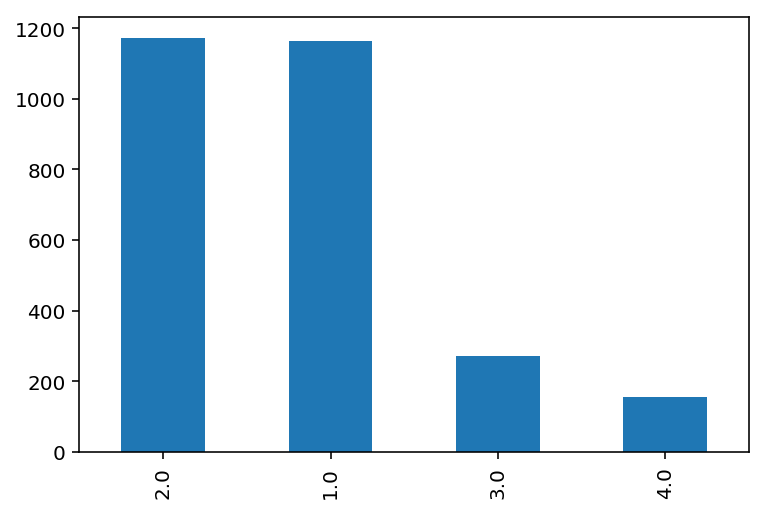

In [26]:
data.price.value_counts().plot(kind='bar')

In [167]:
vis = Visualization()
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, 
                             preprocessor = None)
RANDOM_STATE = 0
seed = 18
np.random.seed(seed)

In [168]:
#ADD MORE FEATURES
add_feats = data[['category','rating','latitude','longitude','likes']]
a_feats = add_feats.values

In [169]:
train_size = 0.7
add_feats = True
x_fts = vectorizer.fit_transform(data['rel_words'])
x_fts = x_fts.toarray()

if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)

#x_fts = a_feats 

pca = decomposition.PCA(n_components=10)
pca.fit(x_fts)
x_fts = pca.transform(x_fts)


    
train_size = int(len(x_fts)* train_size)
#shuffle(data)

x_train, y_train = x_fts[0:train_size], data['price'][0:train_size]
X_test, Y_test = x_fts[train_size:], data['price'][train_size:]

In [170]:
ros = RandomUnderSampler(random_state=RANDOM_STATE)

x_train, y_train = ros.fit_sample(x_train, y_train)
#X_test, Y_test = ros.fit_sample(X_test, Y_test)

In [171]:
cross_validation =   StratifiedKFold (y_train,n_folds=5, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_train[train_index], y_train[train_index]
    dx_test, dy_test = x_train[test_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1)
    #clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[428:])
    
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

Average precision : 0.408
Average recall : 0.578
Average F-score : 92.0


In [172]:

clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1,random_state=RANDOM_STATE)
#clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE,probability=True)
#clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [173]:
test_preds = clf.predict(X_test)

In [174]:
print(classification_report_imbalanced(y_pred=test_preds,y_true=Y_test))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.49      0.32      0.70      0.39      0.51      0.26       390
        2.0       0.48      0.32      0.77      0.39      0.55      0.30       332
        3.0       0.11      0.19      0.86      0.14      0.31      0.09        68
        4.0       0.05      0.28      0.72      0.08      0.21      0.04        39

avg / total       0.44      0.31      0.74      0.35      0.50      0.25       829



In [175]:
clf.score(X_test,Y_test)

0.30880579010856452

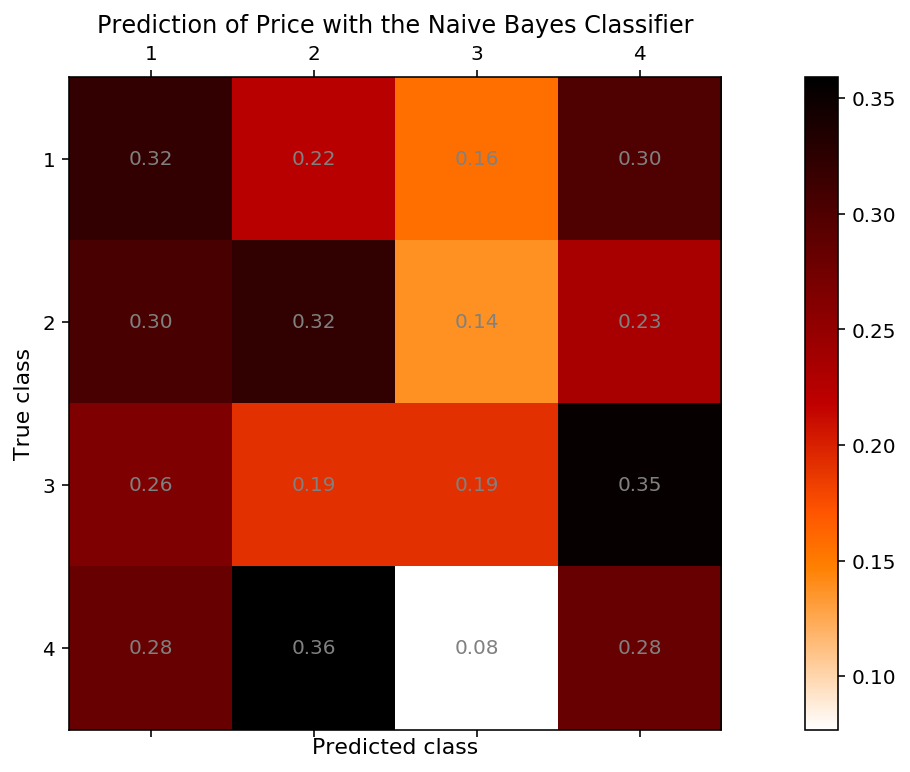

In [176]:
vis.plot_confusion_matrix(Y_test, test_preds, 
                          'Prediction of Price with the Naive Bayes Classifier',color='gray')